## Imports

In [1]:
import os
import glob
import datetime
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import plotly.express as px
import plotly.graph_objects as go
import tf2onnx
import tensorflow as tf

2025-04-08 09:09:59.650714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Chemins d'accès

In [2]:
# Chemins des dossiers contenant les fichiers CSV
base_path = './data/processed'
names = sorted(['Antoine', 'Corentin', 'Felix', 'Leo', 'Vladislav', 'Matthieu', 'Serge'])

# Liste pour stocker les données et les étiquettes
train_data = []
train_labels = []

test_data = []
test_labels = []

# LA VARIABLE LA PLUS IMPORTANTE, C'EST LA TAILLE DES SEQUENCES
frame_size = 250

print(names)

['Antoine', 'Corentin', 'Felix', 'Leo', 'Matthieu', 'Serge', 'Vladislav']


## Préparation des données

In [3]:
# Fonction pour créer des séquences de données
# Hop_length c'est à dire le pas entre les séquences générées.
# Si tu veux que les séquences se chevauchent, tu peux mettre hop_length < frame_size
# Si tu veux que les séquences soient disjointes, tu peux mettre hop_length = frame_size
def create_frames(data, frame_size=250, hop_length=1):
    frames = []
    for start in range(0, len(data) - frame_size + 1, hop_length):
        frame = data[start:start + frame_size]
        if len(frame) == frame_size:
            frames.append(frame)
    return np.array(frames)

### Création des séquences

In [4]:
# Charger les données
all_test_files = []
for name in names:
    folder_path = os.path.join(base_path, name)
    all_files = sorted(glob.glob(folder_path + '/*.csv'))
    # Ça c'est pour savoir quel est ton train test split, ici on prend 5 fichiers au hasard par personne pour le test
    # Donc ça veut dire 50% des données de chaque personne sont pour le test
    test_files = all_files[:5]
    all_test_files.extend(test_files)
    for file_path in all_files:
        file_path_no_prefix = os.path.basename(file_path)
        df = pd.read_csv(file_path)
        acc_data = df['acceleration (g)'].values

        # Créer des trames à partir des données d'accélération
        frames = create_frames(acc_data, frame_size=frame_size, hop_length=1)

        # Train test split
        if file_path in test_files:
            for frame in frames:
                test_data.append(frame)
                test_labels.append(name)
        else:
            for frame in frames:
                train_data.append(frame)
                train_labels.append(name)
                
print(all_test_files)

['./data/processed/Antoine/accelerometer10_data.csv', './data/processed/Antoine/accelerometer1_data.csv', './data/processed/Antoine/accelerometer2_data.csv', './data/processed/Antoine/accelerometer3_data.csv', './data/processed/Antoine/accelerometer4_data.csv', './data/processed/Corentin/accelerometer10_data.csv', './data/processed/Corentin/accelerometer1_data.csv', './data/processed/Corentin/accelerometer2_data.csv', './data/processed/Corentin/accelerometer3_data.csv', './data/processed/Corentin/accelerometer4_data.csv', './data/processed/Felix/accelerometer10_data.csv', './data/processed/Felix/accelerometer1_data.csv', './data/processed/Felix/accelerometer2_data.csv', './data/processed/Felix/accelerometer3_data.csv', './data/processed/Felix/accelerometer4_data.csv', './data/processed/Leo/accelerometer10_data.csv', './data/processed/Leo/accelerometer1_data.csv', './data/processed/Leo/accelerometer2_data.csv', './data/processed/Leo/accelerometer3_data.csv', './data/processed/Leo/accele

In [5]:
# Convertir en tableaux numpy
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Encoder les prénoms
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_encoded = to_categorical(train_labels_encoded)
test_labels_encoded = to_categorical(test_labels_encoded)

In [ ]:
print(train_data.shape)

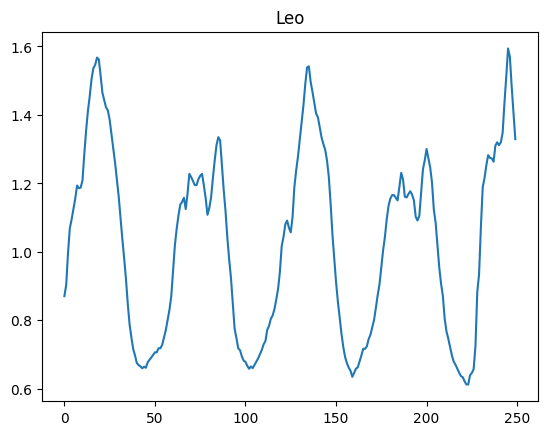

In [6]:
# Pour voir une séquence au pif
def plot_random_frame(data, labels):
    idx = np.random.randint(0, len(data), 1)
    plt.plot(data[idx].flatten())
    plt.title(labels[idx][0])
    plt.show()

plot_random_frame(train_data, train_labels)

In [7]:
print(train_data.shape, train_labels_encoded.shape)
print(test_data.shape, test_labels_encoded.shape)

(22477, 250) (22477, 7)
(23774, 250) (23774, 7)


In [8]:
X_train, X_test, y_train, y_test = train_data.reshape(train_data.shape[0], train_data.shape[1], 1), test_data.reshape(test_data.shape[0], test_data.shape[1], 1), train_labels_encoded, test_labels_encoded

In [9]:
model = Sequential([
    InputLayer(input_shape=(frame_size, 1)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(len(names), activation="softmax")
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(model.input_shape)

/usr/local/Caskroom/miniconda/base/envs/arduino-streamlit/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,055 (258.03 KB)

 Trainable params: 66,055 (258.03 KB)

 Non-trainable params: 0 (0.00 B)

(None, 250, 1)


In [18]:
# Construire le modèle
model = Sequential([
    InputLayer(input_shape=(frame_size, 1)),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=6, strides=6),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(names), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(model.input_shape)

/usr/local/Caskroom/miniconda/base/envs/arduino-streamlit/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 248, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 124, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 122, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,519 (533.28 KB)

 Trainable params: 136,519 (533.28 KB)

 Non-trainable params: 0 (0.00 B)

(None, 250, 1)


In [ ]:
# Construire le modèle
model = Sequential([
    InputLayer(input_shape=(frame_size, 1)),
    Conv1D(8, 3, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(8, 3, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(8, 3, activation='relu'),
    MaxPooling1D(pool_size=6, strides=6),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(names), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(model.input_shape)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 248, 8)         │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 62, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 60, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 13, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 3, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 1, 8)           │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,823 (22.75 KB)

 Trainable params: 5,823 (22.75 KB)

 Non-trainable params: 0 (0.00 B)

(None, 250, 1)


In [63]:

# Entraîner le modèle
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1963 - loss: 1.8905 - val_accuracy: 0.3850 - val_loss: 1.5649
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3853 - loss: 1.4342 - val_accuracy: 0.4308 - val_loss: 1.4304
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5159 - loss: 1.2201 - val_accuracy: 0.4668 - val_loss: 1.3096
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5713 - loss: 1.0749 - val_accuracy: 0.4390 - val_loss: 1.3249
Epoch 5/10
702/703 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6254 - loss: 0.9267

KeyboardInterrupt: 

In [54]:
accuracy = history.history['val_accuracy'][-1]
print(accuracy)

0.6114662885665894


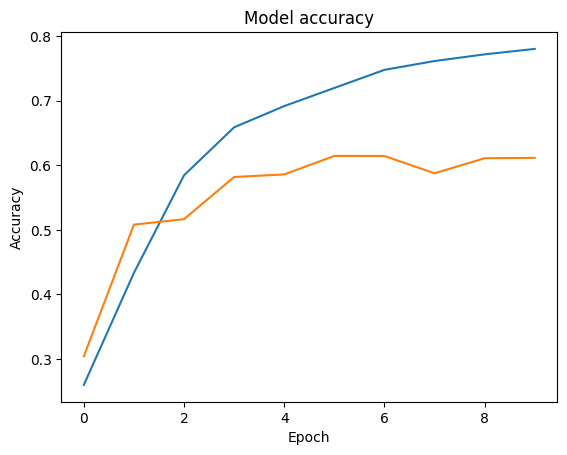

In [55]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)

In [44]:
def save_model(model, name):
    path = f'models/{name}_{accuracy*100:.2f}_{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}'
    os.mkdir(path)
    with open(f'{path}/summary.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    with open(f'{path}/test_files.txt', 'w') as f:
        f.write('\n'.join(all_test_files))
    model.save(f"{path}/model_{frame_size}.keras")
    model.output_names = ["output"]
    spec = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)]
    output_path = f"{path}/model_{frame_size}.onnx"
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec)
    with open(output_path, "wb") as f:
        f.write(model_proto.SerializeToString())
    
    
save_model(model, 'cnn_3layers_32_32_32')

2025-04-08 09:54:34.441143: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-04-08 09:54:34.653723: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


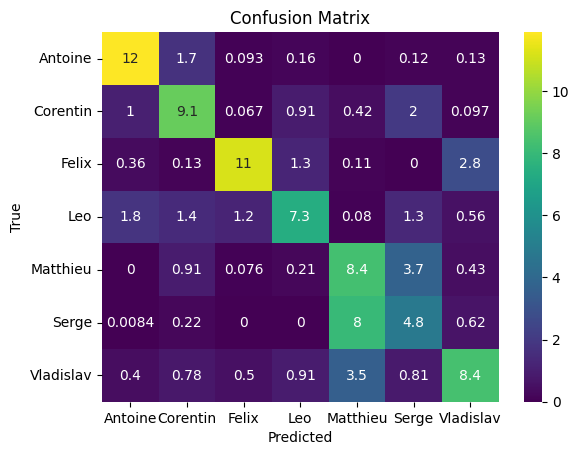

In [56]:
y_pred = model.predict(X_test)

conf = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))/len(y_test) * 100
sns.heatmap(conf, annot=True, xticklabels=names, yticklabels=names, cmap="viridis")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [57]:
def predict(df):
    frames = create_frames(df['acceleration (g)'].values, frame_size=frame_size, hop_length=1)
    frames = frames.reshape(frames.shape[0], frames.shape[1], 1)
    print(frames.shape)
    predictions = model.predict(frames)
    predictions_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    #predictions_labels = [names[label] for label in predictions_labels]
    return predictions_labels


test_recording_path = "data/processed/Leo/accelerometer10_data.csv"
df = pd.read_csv(test_recording_path)

predictions = predict(df)

print(predictions[:100])


(650, 250, 1)
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
['Antoine' 'Antoine' 'Antoine' 'Antoine' 'Antoine' 'Serge' 'Serge' 'Serge'
 'Serge' 'Antoine' 'Antoine' 'Antoine' 'Antoine' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Antoine' 'Antoine' 'Antoine'
 'Antoine' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Corentin' 'Corentin' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Matthieu' 'Serge' 'Matthieu' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge'
 'Serge' 'Serge' 'Serge' 'Serge' 'Serge' 'Serge']


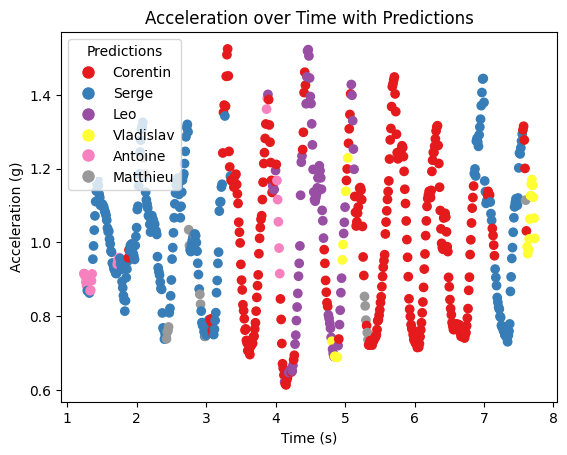

Counter({'Corentin': 288,
         'Serge': 232,
         'Leo': 70,
         'Vladislav': 22,
         'Antoine': 20,
         'Matthieu': 18})

In [58]:

def show_predictions(df, predictions):
    n = len(predictions)
    m = len(df)
    # Create a colormap
    c = Counter(predictions)
    mc = c.most_common()
    sorted_list = [x[0] for x in mc]
    unique_predictions = sorted_list
    colors = plt.get_cmap('Set1', len(unique_predictions))
    color_map = {label: colors(i) for i, label in enumerate(unique_predictions)}
    
    # Plot the data with colors based on predictions
    fig, ax = plt.subplots()
    ax.scatter(df['time (s)'][(m-n)//2:n+(m-n)//2], df['acceleration (g)'][(m-n)//2:n+(m-n)//2], c=[color_map[label] for label in predictions])
    
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=10) for label in sorted_list]
    plt.legend(handles, sorted_list, title="Predictions")
    
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    plt.title('Acceleration over Time with Predictions')
    plt.show()
    
    return c

show_predictions(df, predictions)

In [ ]:
def make_bar_graph(df,predictions):
    new_df = df[:len(predictions)]
    new_df.insert(5,"prediction",predictions)
    
    fig = px.bar(new_df, x="time (s)" ,y="acceleration (g)", color="prediction")
    fig.update_layout(bargap=0)
    return fig

make_bar_graph(df,predictions)

In [ ]:
def to_gantt(predictions):
    output_data = []
    start = 0
    finish = 1
    state = predictions[0]
    for i, prediction in enumerate(predictions):
        finish = i
        if prediction != state:
            output_data.append({'prediction' : state, "start" : start, "finish" : finish})
            start = finish
            state = prediction
    output_data.append({'prediction' : state, "start" : start, "finish" : finish})
    output_df = pd.DataFrame(output_data)
    return output_df
            
gantt = to_gantt(predictions)

gantt.head()

In [ ]:
color_scheme = {name : color for name, color in zip(names,px.colors.qualitative.Plotly)}

def make_area_plot(df,gantt):
    nameset = set()
    fig = go.Figure()
    for i, row in gantt.iterrows():
        start = row["start"]
        finish = row["finish"]
        name = row["prediction"]
        df_subset = df[start:finish+1]
        trace = go.Scatter(
            x = df_subset["time (s)"],
            y = df_subset["acceleration (g)"],
            mode="lines",
            fill='tozeroy',
            line_color = color_scheme[name],
            legendgroup=name,
            name=name,  
        )
        if name in nameset:
            trace.update(showlegend=False)
        else:
            nameset.add(name)
        fig.add_trace(trace)
    
    fig.update_layout(
        title="Prédicitons de l'utilisateur",
        xaxis_title="Time (s)",
        yaxis_title="Acceleration (g)",
        showlegend=True,
        legend_title_text='Prédictions',
    )
    
    return fig




make_area_plot(df,gantt) 